In [1]:
import pandas as pd
from pathlib import Path
import xgboost
import shap
import omegaconf

import sys
sys.path.append('../')

from src.data import get_dataset
from hydra import initialize, compose

shap.initjs()

init_hydra = initialize('../src/conf/')

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection
from sklearn.preprocessing import scale, normalize
from sklearn import datasets, cluster
from sklearn import neighbors, ensemble, tree, linear_model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [7]:
config = compose(config_name='train_base_paper.yaml')
dataset = config.datasets[config.dataset_identifier]

train_image, train_meta, train_brixia, train_prognosis, train_death = get_dataset(
    table_path=dataset.train_table,
    brixia_score_base_path=config.brixia_score_base_path,
    config=config
)

test_image, test_meta, test_brixia, test_prognosis, test_death = get_dataset(
    table_path=dataset.test_table,
    brixia_score_base_path=config.brixia_score_base_path,
    config=config,
    split="test",
)

whole_test_df = pd.read_excel('/mnt/ncshare/ai4covid_hackathon/raw_data/completeTestClinData.xls')
test_raw_df = whole_test_df[ ['ImageFile', 'Prognosis'] ]
test_raw_df.Prognosis.replace('SEVERE', 1, inplace=True)
test_raw_df.Prognosis.replace('MILD', 0, inplace=True)

test_prognosis = np.array(pd.get_dummies(test_raw_df.Prognosis).values, dtype=float)

X_train = pd.DataFrame(train_meta, columns=dataset.feature_cols)
X_test = pd.DataFrame(test_meta, columns=dataset.feature_cols)

for ind in range(train_brixia.shape[-1]):
    X_train[f'brixia_{ind}'] = train_brixia[:, ind]
    
for ind in range(test_brixia.shape[-1]):
    X_test[f'brixia_{ind}'] = test_brixia[:, ind]
    
Y_train = np.argmax(train_prognosis, axis=1)
Y_test = np.argmax(test_prognosis, axis=1)

In [8]:
X_train.head()

,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,...,Hospital_C,Hospital_D,Hospital_E,Hospital_F,brixia_0,brixia_1,brixia_2,brixia_3,brixia_4,brixia_5
0,0.490163,1.0,1.0,-0.256402,0.271422,1.0,0.0,-0.451167,0.011004,-0.484840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
1,-1.900581,0.0,1.0,1.779697,0.271422,1.0,0.0,-0.349484,0.942178,0.162847,...,0.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0
2,-0.485936,0.0,1.0,-0.561816,0.271422,0.0,0.0,1.141870,1.605287,0.501141,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0
3,-1.696123,1.0,1.0,-0.358206,-0.708205,1.0,0.0,0.800319,-1.583279,-0.537554,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
4,-1.364867,0.0,1.0,0.456233,0.271422,1.0,0.0,-0.120045,1.379548,-0.464476,...,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,1.0,2.0


In [9]:
X_test.head()

,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,...,Hospital_C,Hospital_D,Hospital_E,Hospital_F,brixia_0,brixia_1,brixia_2,brixia_3,brixia_4,brixia_5
0,0.755167,1.0,1.0,-1.579866,1.251049,0.0,1.0,-1.016943,-0.750866,-0.455608,...,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0
1,-0.039846,0.0,1.0,-1.579866,-1.687832,0.0,0.0,-0.547636,0.293178,-0.539525,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0
2,1.483929,1.0,1.0,0.049013,-0.708205,0.0,0.0,-0.365127,-1.160018,-0.507995,...,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0
3,0.755167,1.0,1.0,-1.579866,0.000000,0.0,1.0,-1.016943,-0.750866,-0.455608,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4,0.821418,1.0,1.0,-1.478061,-1.687832,0.0,1.0,-1.173379,2.564678,-0.532792,...,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0


In [10]:
Y_train[:5], Y_test[:5]

(array([1, 0, 0, 0, 1]), array([0, 0, 0, 1, 1]))

In [11]:
def five_fold_cv_model_eval(model, x_train, x_test, y_train, y_test, columns):
    try:
        model_instance = model(n_jobs=8)
    except:
        model_instance = model()
        
    b_accs = []
    roc_aucs = []
    f1s = []
    
    test_b_accs = []
    test_roc_aucs = []
    test_f1s = []
    
    scores = {}
    
    for fold in range(5):
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

        model_instance.fit(x_train, y_train)
        try:
            pred_values_label = model_instance.predict(x_valid)
            b_acc = metrics.balanced_accuracy_score( y_pred=pred_values_label, y_true=y_valid )
            f1 = metrics.f1_score( y_true=y_valid, y_pred=pred_values_label )
            f1s.append(f1)
            b_accs.append(b_acc)

            ## TEST
            pred_test_labels = model_instance.predict(x_test)
            test_b_accs.append(metrics.balanced_accuracy_score(y_true=y_test, y_pred=pred_test_labels))
            test_f1s.append(metrics.f1_score(y_true=y_test, y_pred=pred_test_labels))
        except:
            print('', end='\r')

        try:
            pred_values_proba = model_instance.predict_proba(x_valid)            
            roc_auc = metrics.roc_auc_score( y_true=y_valid, y_score=pred_values_proba[:,1] )
            roc_aucs.append(roc_auc)

            ## TEST
            pred_test_labels = model_instance.predict_proba(x_test)
            test_roc_aucs.append(metrics.roc_auc_score(y_true=y_test, y_pred=pred_test_labels[:, 1]))
        except:
            try:
                # this is added for SVM proba pred
                model_instance = model(probability=True)
                model_instance.fit(x_train, y_train)
                pred_values_proba = model_instance.predict_proba(x_valid)
                roc_auc = metrics.roc_auc_score( y_true=y_valid, y_score=pred_values_proba[:,1] )
                roc_aucs.append(roc_auc)

                ## TEST
                pred_test_labels = model_instance.predict_proba(x_test)
                test_roc_aucs.append(metrics.roc_auc_score(y_true=y_test, y_pred=pred_test_labels[:, 1]))
            except:
                print('', end='\r')
    
    scores['balanced_accuracy'] = b_accs
    scores['roc_auc'] = roc_aucs
    scores['f1'] = f1s
    
    scores['test_balanced_accuracy'] = test_b_accs
    scores['test_roc_auc'] = test_roc_aucs
    scores['test_f1'] = test_f1s
    
    try:
        explainer = shap.Explainer(model_instance, x_train, feature_names=columns)
        shap_values = explainer(x_test)
        scores['test_shap_values'] = shap_values
        scores['explainer'] = explainer
    except Exception as e:
        try:
            explainer = shap.KernelExplainer(model_instance.predict_proba, x_train, feature_names=columns)
            shap_values = explainer.shap_values(shap.sample(x_test, 10))
            scores['test_shap_values'] = shap_values
            scores['explainer'] = explainer
        except Exception as e:
            print('EXCEPTION:\t', e)
    
    return scores, model_instance

In [12]:
models_to_run = { 'logistic': linear_model.LogisticRegression, 'SVM': svm.SVC, 
                  'RandomForest': ensemble.RandomForestClassifier,
                  'GradientBoosting': ensemble.GradientBoostingClassifier,
                  'XGB': XGBClassifier}

In [13]:
def legend_without_duplicate_labels(ax):
    # https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib/40870637
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), prop={'size': 22}, loc='lower right')
    
def fit_and_eval_models(num_to_model, models_to_run,
                        fig, color='blue', m='o', shift=0):
    all_scores = { model : None for num, model in num_to_model.items() }
    for i in range( len(num_to_model) ):
        current_model = num_to_model[i]
        print(current_model)

        scores, model = five_fold_cv_model_eval(models_to_run[current_model], X_train, X_test,
                                                Y_train, Y_test, X_train.columns)

        ax1 = plt.subplot(131)
        value = np.mean( scores['balanced_accuracy'] )
        std_err = np.std( scores['balanced_accuracy'] ) / np.sqrt(5)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('Balanced accuracy score', size=30)
        plt.grid(True)
        sc.set_label('data')
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax1)        

        ax2 = plt.subplot(132)
        value = np.mean( scores['roc_auc'] )
        std_err = np.std( scores['roc_auc'] ) / np.sqrt(5)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('Roc auc score', size=30)
        plt.grid(True)
        sc.set_label('data')
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax2)        

        ax3 = plt.subplot(133)
        value = np.mean( scores['f1'] )
        std_err = np.std( scores['f1'] ) / np.sqrt(5)
        
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('F1 score', size=30)
        plt.grid(True)
        sc.set_label('data')
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax3)
            
        all_scores[current_model] = scores
    
    return all_scores

In [14]:
num_to_model = dict( zip( np.arange(len(models_to_run)), list(models_to_run.keys()) ) )

logistic
SVM


Using 360 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



RandomForest


Using 360 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



GradientBoosting


Using 360 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



XGB
[09:35:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:35:08] WARNING: ../src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:35:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:35:54] WARNING: ../src/learner.cc:576: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with

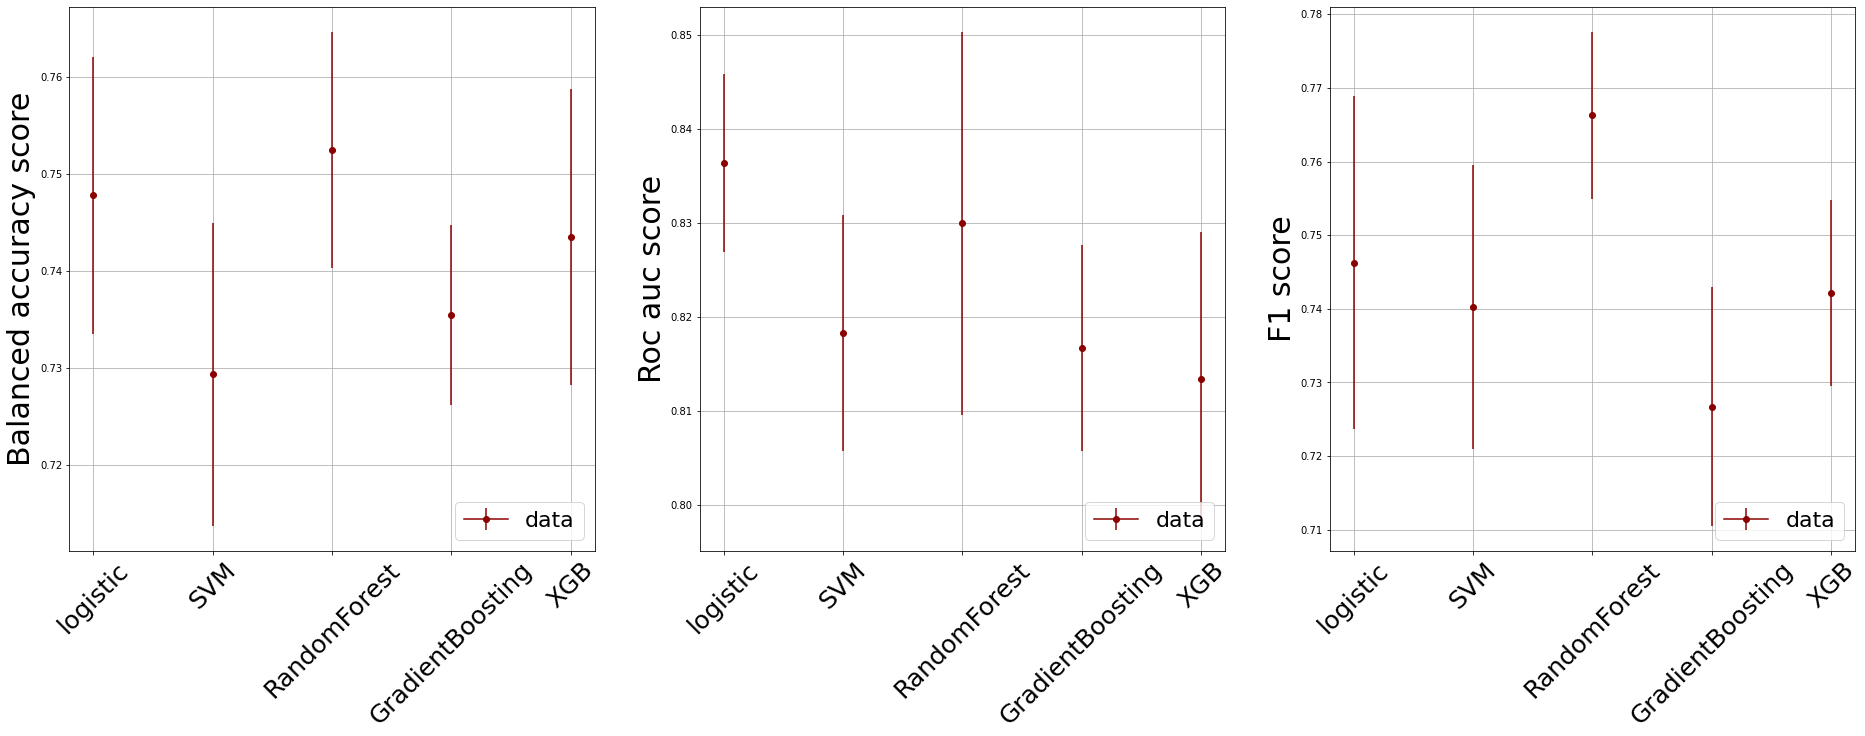

In [15]:
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(32, 10))
scores = fit_and_eval_models( num_to_model, models_to_run, fig, color='darkred', m='o', shift=0)

In [20]:
print('Models with brixia\n\n')
for model, _scores in scores.items():
    print(f'{model} BA  :', '$', np.around(np.mean(_scores['balanced_accuracy']), 3), '\pm',
          np.around(np.std(_scores['balanced_accuracy']), 3), '$')
    print(f'{model} F1  :', '$', np.around(np.mean(_scores['f1']), 3), '\pm',
          np.around(np.std(_scores['f1']), 3), '$')
    print(f'{model} AUC :', '$', np.around(np.mean(_scores['roc_auc']), 3), '\pm',
          np.around(np.std(_scores['roc_auc']), 3), '$')
    print('\n')
    print('test')
    print('\n')
    print(f'{model} BA  (test):', '$', np.around(np.mean(_scores['test_balanced_accuracy']), 3), '\pm',
          np.around(np.std(_scores['test_balanced_accuracy']), 3), '$')
    print(f'{model} F1  (test):', '$', np.around(np.mean(_scores['test_f1']), 3), '\pm',
          np.around(np.std(_scores['test_f1']), 3), '$')
    print(f'{model} AUC (test):', '$', np.around(np.mean(_scores['test_roc_auc']), 3), '\pm',
          np.around(np.std(_scores['test_roc_auc']), 3), '$')
    print('*'*100)
    print('\n')

Models with brixia


logistic BA  : $ 0.748 \pm 0.032 $
logistic F1  : $ 0.746 \pm 0.051 $
logistic AUC : $ 0.836 \pm 0.021 $


test


logistic BA  (test): $ 0.771 \pm 0.006 $
logistic F1  (test): $ 0.714 \pm 0.007 $
logistic AUC (test): $ nan \pm nan $
****************************************************************************************************


SVM BA  : $ 0.729 \pm 0.035 $
SVM F1  : $ 0.74 \pm 0.043 $
SVM AUC : $ 0.818 \pm 0.028 $


test


SVM BA  (test): $ 0.744 \pm 0.005 $
SVM F1  (test): $ 0.689 \pm 0.005 $
SVM AUC (test): $ nan \pm nan $
****************************************************************************************************


RandomForest BA  : $ 0.753 \pm 0.027 $
RandomForest F1  : $ 0.766 \pm 0.025 $
RandomForest AUC : $ 0.83 \pm 0.046 $


test


RandomForest BA  (test): $ 0.739 \pm 0.01 $
RandomForest F1  (test): $ 0.68 \pm 0.012 $
RandomForest AUC (test): $ nan \pm nan $
************************************************************************************

Models with brixia


logistic


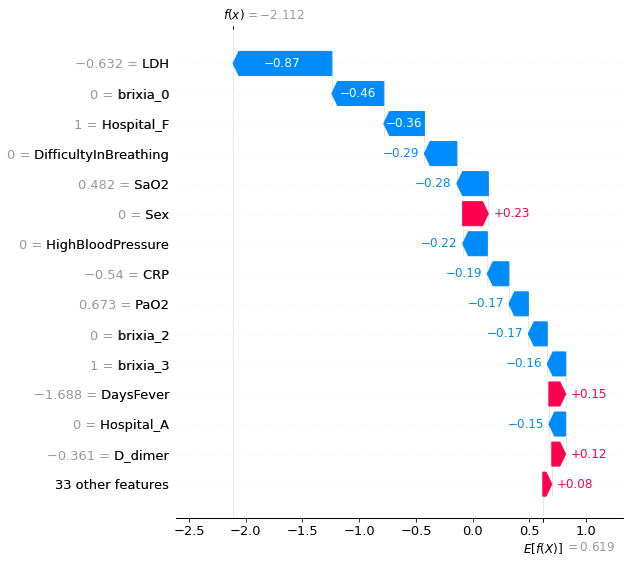

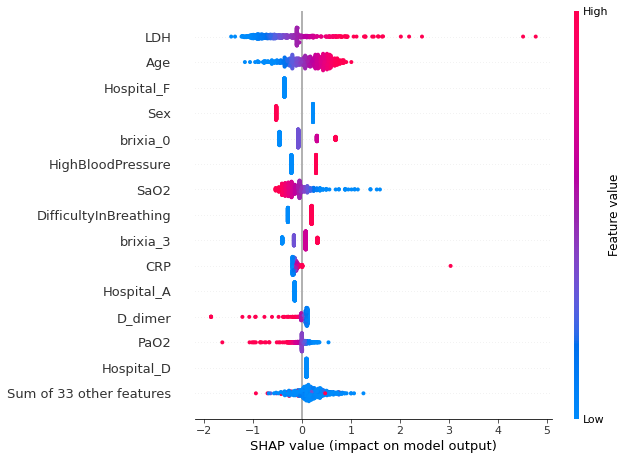

SVM
RandomForest
GradientBoosting
XGB


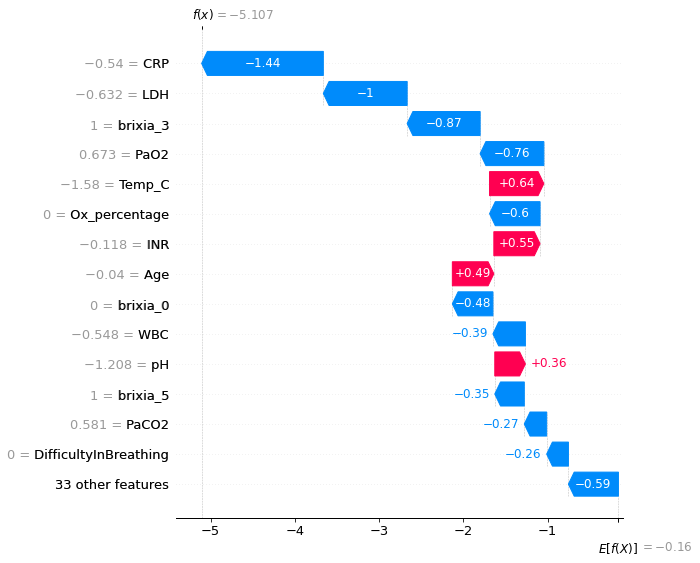

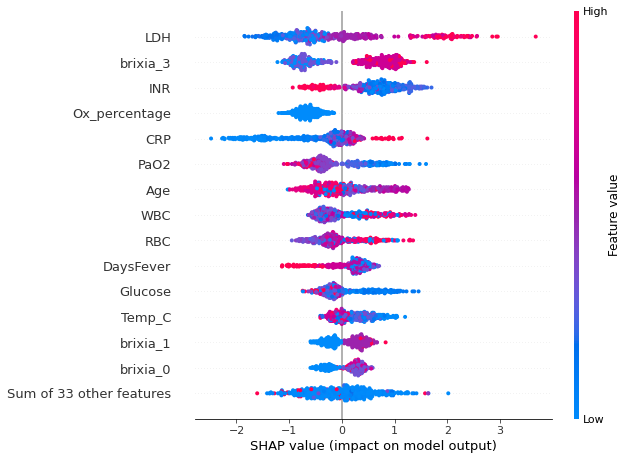

In [22]:
print('Models with brixia\n\n')
for model, _scores in scores.items():
    idx = 1
    print(model)
    try:
        shap.plots.waterfall(_scores['test_shap_values'][1], max_display=15)
        shap.plots.beeswarm(_scores['test_shap_values'], max_display=15)
    except Exception as e:
        #print(e)  
        #print(_scores['test_shap_values'][0].shape, _scores['test_shap_values'][1].shape)
        #shap.force_plot(_scores['explainer'].expected_value[0], _scores['test_shap_values'][1],
        #                X_test, show=True)
        continue